In [1]:
import grasp2alm as g2a
import numpy as np
import healpy as hp
import math
import os
import matplotlib.pyplot as plt
from math import factorial

In [2]:
pol = True
nside: int = 1024
lmax: int = 2*nside
beam_fwhm_deg = 0.5
beam_fwhm = np.deg2rad(beam_fwhm_deg)
beam_sigma = beam_fwhm/np.sqrt(8.0*np.log(2.0))
amplitude = 1/(2*np.pi*beam_sigma*beam_sigma)
bias = 0.0

In [3]:
beam_fwhm_deg

0.5

In [4]:
vini: float = beam_fwhm_deg*4
vnum = 30001
vinc: float = abs(vini)*2/vnum
c = 0
ncut = 50
header_1: str = "Field data in cuts"
header_2 = f"{vini} {vinc} {vnum} {c} 3 1 2"

theta = np.linspace(vini, -vini, vnum)
theta = np.deg2rad(theta)

phi = np.linspace(0, 180-180/ncut, ncut)

The gaussian beam in $\theta,\phi$ coordinates is:
$$
B(\theta)=\frac{1}{2\pi\sigma^2}\exp{-\frac{\theta^2}{2\sigma^2}}
$$
alternatively, we can follow _Challinor et al_ by using:
$$
B(\theta)=\frac{1}{2\pi\sigma^2}\exp{-\frac{1-\cos(\theta)}{\sigma^2}}
$$

In [5]:
def my_gauss(amplitude, sigma, theta, bias = 0.0):
    return amplitude * np.exp(- np.sin(theta)**2 / (2*sigma**2)) + bias

#def my_gauss(amplitude, sigma, theta, bias = 0.0):
#    return amplitude * np.exp(- (1-np.cos(theta)) / (sigma**2)) + bias

In [6]:
with open('prova.cut', 'w') as file:
    for n in range(ncut):
        file.write(header_1)
        file.write('\n')
        file.write(header_2)
        file.write('\n')
        for i in range(vnum):
            co_i = np.emath.sqrt(my_gauss(amplitude, beam_sigma, theta[i], bias))
            cx_i = 0.0
            file.write(f"{np.real(co_i)} {np.imag(co_i)} {np.real(cx_i)} {np.imag(cx_i)}\n")

In [7]:
if os.path.exists('prova.cut'):
    cut = g2a.BeamCut('prova.cut')
    os.remove('prova.cut')

In [8]:
outOftheta_val = hp.UNSEEN
cpolar = cut.to_polar(copol_axis="y")

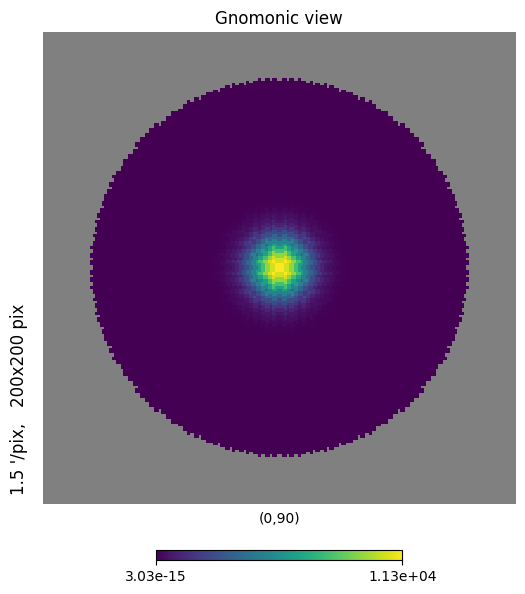

In [9]:
cmap = cpolar.to_map(nside, outOftheta_val=outOftheta_val, interp_method='linear')
hp.gnomview(cmap.map[0], rot=[0,90])

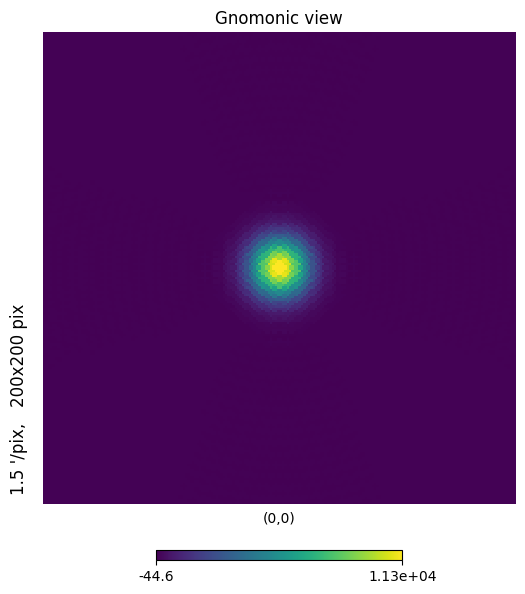

In [10]:
# Rotate the beam into x-direction
rot_matrix = (0,-90,0)
r = hp.Rotator(rot=rot_matrix, inv=True, deg=True)
cmap.map = np.array(r.rotate_map_alms(cmap.map))
hp.gnomview(cmap.map[0])

In [11]:
calm = cmap.to_alm(lmax=lmax, use_pixel_weights=True)

In [12]:
r_alm = r.get_inverse()
calm = r_alm.rotate_alm(calm, lmax=lmax)

# Compare against theoric

Following LevelS convention:
$$
a_{lm}^T=\sqrt\frac{2l+1}{4\pi}\exp{(-\frac{\sigma^2}{2}l^2)} \\
a_{lm}^E=-\sqrt{2}\sqrt\frac{2l+1}{32\pi}\exp{(-\frac{\sigma^2}{2}l^2)} \\
a_{lm}^B=i*a_{lm}^E
$$

*Two problems:*
- The $\sqrt{2}$ is absent into healpy convention
- The $l^2$ inside the exponential doesn't work well, instead we decided to use $l(l+1)$

See the following issue: https://github.com/healpy/healpy/issues/861

In [13]:
from scipy.special import iv,ive

def my_blm_gauss(fwhm:float, lmax:int, pol:bool=False):
    mmax = 2 if pol else 0
    ncomp = 3 if pol else 1
    nval = hp.Alm.getsize(lmax, mmax)

    if mmax > lmax:
        raise ValueError("lmax value too small")

    blm = np.zeros((ncomp, nval), dtype=np.complex128)
    sigmasq = fwhm * fwhm / (8 * np.log(2.0))

    for l in range(0, lmax + 1):
        blm[0, hp.Alm.getidx(lmax, l, 0)] = \
            np.sqrt((2 * l + 1) / (4.0 * np.pi)) * \
            np.exp(-0.5 * sigmasq * l * (l + 1))

    if pol:
        for l in range(2, lmax + 1):
            blm[1, hp.Alm.getidx(lmax, l, 2)] = \
                np.sqrt((2 * l + 1) / (32 * np.pi)) * \
                np.exp(-0.5 * sigmasq * l * (l + 1))
        blm[2] = 1j * blm[1]

    # Adjust normalization

    blm[1] = -blm[1] * np.sqrt(2.0)
    blm[2] = -blm[2] * np.sqrt(2.0)

    return blm

In [14]:
#blm=hp.blm_gauss(beam_fwhm, lmax=lmax, pol=pol)
blm=my_blm_gauss(beam_fwhm, lmax=lmax, pol=pol)

In [15]:
index_0 = hp.Alm.getidx(lmax, np.arange(lmax), 0)
index_2 = hp.Alm.getidx(lmax, np.arange(lmax), 2)
indexes = [index_0, index_2, index_2]

In [16]:
alm_T_0_yusuke = calm[0][index_0]
alm_E_2_yusuke = calm[1][index_2]
alm_B_2_yusuke = calm[2][index_2]
alm_yusuke = np.array([alm_T_0_yusuke, alm_E_2_yusuke, alm_B_2_yusuke])

alm_T_0_hp = blm[0][index_0]
alm_E_2_hp = blm[1][index_2]
alm_B_2_hp = blm[2][index_2]
alm_hp = np.array([alm_T_0_hp, alm_E_2_hp, alm_B_2_hp])

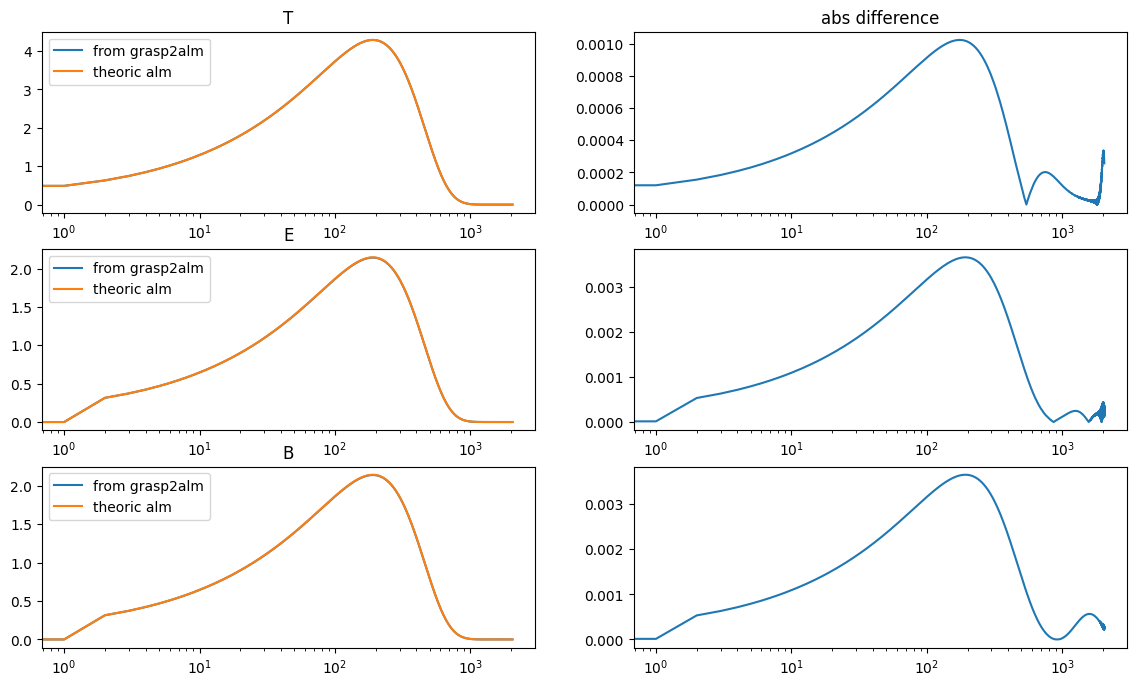

In [47]:
fig, axs = plt.subplots(3,2, figsize=(14,8))
for indx, stokes in enumerate('TEB'):
    axs[indx,0].plot(abs(alm_yusuke[indx]), label='from grasp2alm')
    axs[indx,0].plot(abs(alm_hp[indx]), label='theoric alm')
    axs[indx,0].set_title(stokes)
    axs[indx,0].legend()

    axs[0,1].set_title('abs difference')
    axs[indx,1].plot( abs(alm_yusuke[indx]-alm_hp[indx]) )

    axs[indx,0].set_xscale('log')
    axs[indx,1].set_xscale('log')

In [42]:
np.allclose(alm_yusuke[0], alm_hp[0], atol=1e-3)

True

In [19]:
np.allclose(alm_yusuke[1], alm_hp[1], atol=1e-3)

False

In [20]:
np.allclose(alm_yusuke[2], alm_hp[2], atol=1e-3)

False

# Check reconstructed maps

In [21]:
m_g2a = hp.alm2map(calm, lmax=lmax, nside=nside, pol=pol)
m_hp = hp.alm2map(blm, lmax=lmax, mmax=2, nside=nside, pol=pol)

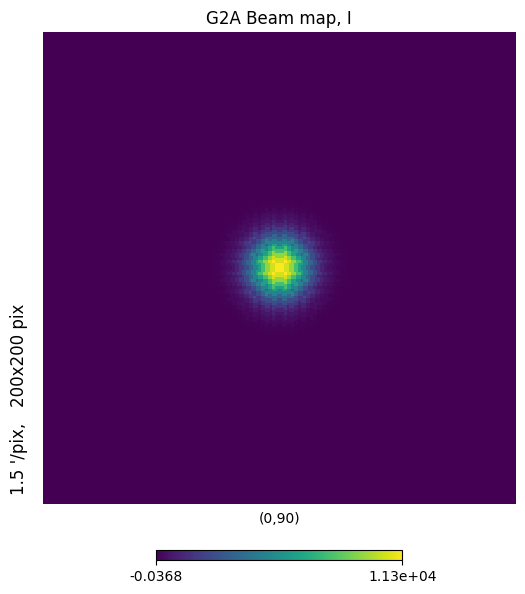

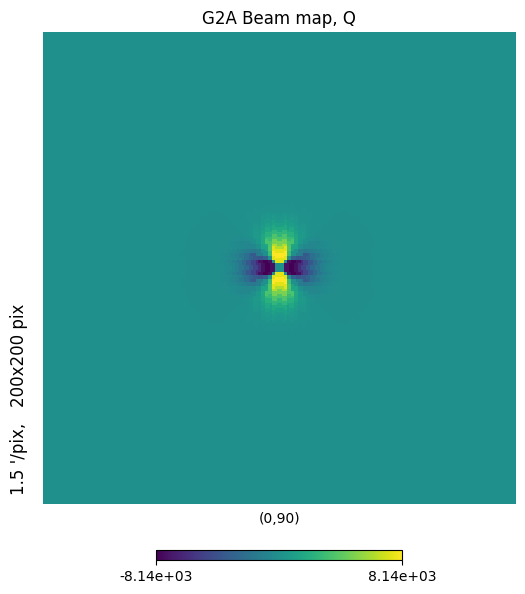

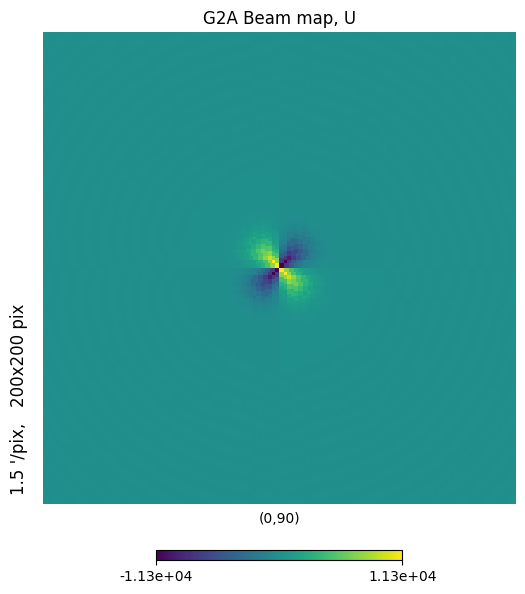

In [22]:
for each_m, label in zip(m_g2a, "IQU"):
    hp.gnomview(each_m, rot=[0, 90], title=f"G2A Beam map, {label}")

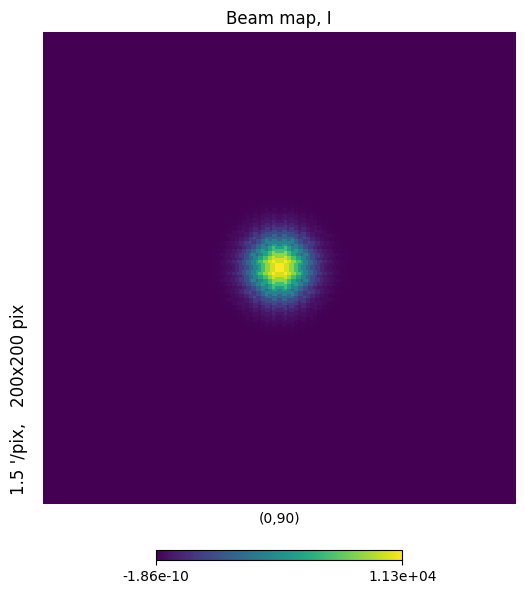

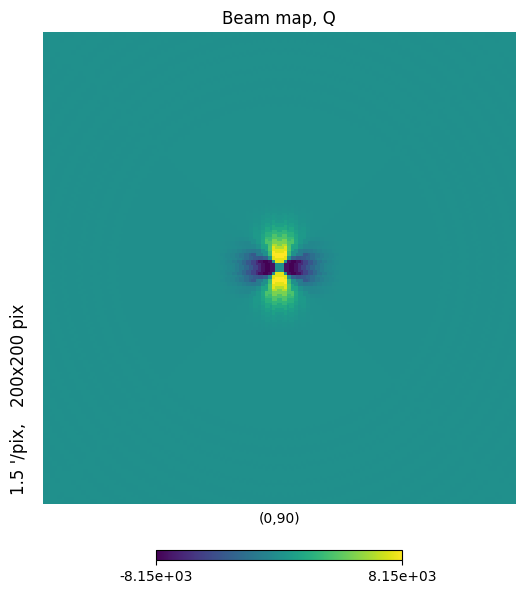

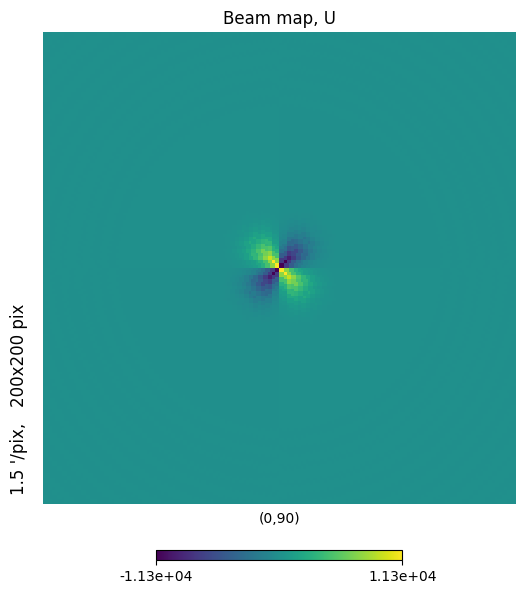

In [23]:
for each_m, label in zip(m_hp, "IQU"):
    hp.gnomview(each_m, rot=[0, 90], title=f"Beam map, {label}")